# Text Summarization: Tfidf,TextRank & Transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

# Install the kaggle package
!pip install kaggle

In [ ]:
!cp /content/drive/MyDrive/CNNUC/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download gowrishankarp/newspaper-text-summarization-cnn-dailymail

100% 503M/503M [00:08<00:00, 125MB/s] 
100% 503M/503M [00:08<00:00, 64.7MB/s]


In [ ]:
! unzip newspaper-text-summarization-cnn-dailymail.zip

Archive:  newspaper-text-summarization-cnn-dailymail.zip
  inflating: cnn_dailymail/test.csv  
  inflating: cnn_dailymail/train.csv  
  inflating: cnn_dailymail/validation.csv  


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import textwrap
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read Dataset

In [ ]:
# Read and Load the Dataset

def load_dataset(dataset_path):
    df = pd.read_csv(dataset_path)
    # Drop id column
    df.drop(columns=['id'],inplace=True)
    # Drop null values (if any)
    df.dropna(inplace=True)
    print("Number of records:",len(df))
    return df

In [ ]:
# Load train data
df_train = load_dataset('cnn_dailymail/train.csv')
df_train.head()

Number of records: 287113


,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
# Define function to wrap text

def wrap(x):
    return textwrap.fill(x,replace_whitespace=False,fix_sentence_endings=True)


print(wrap(df_train['article'][1]))

(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-
Dade Police Department, working in the division that investigates
allegations of wrongdoing by cops.  Outside the office, authorities
allege that the 45-year-old longtime officer worked with a drug
trafficking organization to help plan a murder plot and get guns.  A
criminal complaint unsealed in U.S. District Court in New Jersey
Tuesday accuses Mata, also known as "The Milk Man," of using his role
as a police officer to help the drug trafficking organization in
exchange for money and gifts, including a Rolex watch.  In one
instance, the complaint alleges, Mata arranged to pay two assassins to
kill rival drug dealers.  The killers would pose as cops, pulling over
their targets before shooting them, according to the complaint.
"Ultimately, the (organization) decided not to move forward with the
murder plot, but Mata still received a payment for setting up the
meetings," federal prosecutors said in a statement.  The co

# EDA


# Check Nulls If any

In [ ]:
df_train.isna().sum()

article       0
highlights    0
dtype: int64

In [ ]:
df_val.isna().sum()

article       0
highlights    0
dtype: int64

In [ ]:
df_test.isna().sum()

article       0
highlights    0
dtype: int64

# Data Cleaning

In [ ]:
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.0 MB/s eta 0:00:00


In [ ]:
def re_clean(text):
    import re
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', ' ', text)
    text = re.sub(r'[_\-;%()|+&=*%:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\n',' ',text)
    text = re.sub(' est ',' ',text)
    text = re.sub(r'[?!]','.',text)
    return text

In [ ]:
#used to expand contractions
def expand(text):
    import contractions
    text=text.split()
    final=[]
    for word in text:
        try:
            final.append(contractions.fix(word)+" ")
        except:
            final.append(word+" ")
    return "".join(final)
def remove(texts):
    final=[]
    for text in texts:
        sents=[]
        sentences=text.split(".")
        for sentence in sentences:
            if(len(sentence.split())>=5):
                sents.append(sentence+".")
        final.append("".join(sents))
    return final

# Pre Processing the dataset

In [ ]:
new_texts = []
for text in df_train.iloc[:5000, 1]:
    expanded_text = expand(re_clean(text)).lower()
    cleaned_text = remove(expanded_text)
    new_texts.append(cleaned_text)

In [ ]:
Formatted_summaries = []
for text in df_train.iloc[:5000, 0]:
    expanded_text = expand(re_clean(text)).lower()
    cleaned_text = remove(expanded_text)
    Formatted_summaries.append(cleaned_text)

# Method 1: TF-IDF - Function to Summarize Text using Tfidf

In [ ]:
stop_words = stopwords.words("english")
tfidf = TfidfVectorizer(stop_words=stop_words,norm='l1')

def get_sentence_score(tfidf_row): # Function to get score for each sentence
    x = tfidf_row[tfidf_row != 0]
    return x.mean()

def summarize(text):
    # Extract sentences
    sents = sent_tokenize(text)
    # perform tfidf
    X = tfidf.fit_transform(sents)
    # compute scores for each sentence
    scores = np.zeros(len(sents))
    for i in range(len(sents)):
        score = get_sentence_score(X[i,:])
        scores[i] = score

    # sort the scores
    sort_idx = np.argsort(-scores)

    # print summary
    #print("Summary:")
    #for i in sort_idx[:5]:
        #print(wrap("%2f: %s"%(scores[i],sents[i])))

    final_summary = ""
    for i in sort_idx[:5]:  # Adjust the number of sentences in the summary as needed
        final_summary += sents[i] + " "

    return final_summary.strip()

In [ ]:
# Summary for a row in train data
print("Original Summary : " , wrap(df_train['article'][1]))
print("-"*80)
print("Generated Summary :" , wrap(summarize(df_train['article'][1])))

Original Summary :  (CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-
Dade Police Department, working in the division that investigates
allegations of wrongdoing by cops.  Outside the office, authorities
allege that the 45-year-old longtime officer worked with a drug
trafficking organization to help plan a murder plot and get guns.  A
criminal complaint unsealed in U.S. District Court in New Jersey
Tuesday accuses Mata, also known as "The Milk Man," of using his role
as a police officer to help the drug trafficking organization in
exchange for money and gifts, including a Rolex watch.  In one
instance, the complaint alleges, Mata arranged to pay two assassins to
kill rival drug dealers.  The killers would pose as cops, pulling over
their targets before shooting them, according to the complaint.
"Ultimately, the (organization) decided not to move forward with the
murder plot, but Mata still received a payment for setting up the
meetings," federal prosecutors said in 

In [ ]:
# Summary for a row in train data
print("Original Summary : " , wrap(df_train['article'][70]))
print("-"*80)
print("Generated Summary :" , wrap(summarize(df_train['article'][70])))

Original Summary :  In the battle to be the most extravagant mega yacht on the seas, it
takes a lot to really impress.  While helipads, waterslides, and movie
theatres are commonplace additions to the yachts of the super wealthy,
a stylish Italian vessel is making waves for being the first  to
feature a floating drive-in garage.  J'ade, by Ferretti group company
CRN, features a hydraulic-operated hatch which can store an eight-
metre speedboat without the use of a tender lift to hoist it out of
the water.  Scroll down for video . Innovative: The 196-foot yacht has
a hydraulic-operated hatch which can store an eight-metre speedboat
without the use of a tender lift to hoist it out of the water .
Floating fortress: While swimming pools and helipads are commonplace
on many a mega yacht, J'ade features the world's first floating garage
. Glide in: The internal basin floods and empties 18,000 litres of
water in just three minutes, allowing the boat to enter the yacht
without the use of a cra

# Load validation data

In [ ]:
df_val = load_dataset('cnn_dailymail/validation.csv')
df_val.head()

Number of records: 13368


,article,highlights
0,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


In [ ]:
# Summary for 1st row
print("Original Summary : " , wrap(df_val['article'][1]))
print("-"*80)
print("Generated Summary :" , wrap(summarize(df_val['article'][1])))

Orginal Summary :  A middle-school teacher in China has inked hundreds of sketches that
are beyond be-leaf.  Politics teacher Wang Lian, 35,  has created 1000
stunning ink drawings covering subjects as varied as cartoon
characters and landscapes to animals, birds according to the People's
Daily Online.  The intricate scribbles on leaves feature Wang's
favourite sites across the city of Nanjing, which include the
Presidential Palace, Yangtze River Bridge, the ancient Jiming Temple
and the Qinhuai River.  Natural canvas: Artist and teacher Wang Lian
has done hundreds of drawings, like this temple, on leaves she
collects in the park and on the streets . Delicate: She uses an ink
pen to gently draw the local scenes and buildings on the dried out
leaves . 'Although teaching politics is my job, drawing is my passion
and hobby,' said Wang.  'I first tried drawing on leaves about 10
years ago and fell in love with it as an art form immediately.  'It's
like drawing on very old parchment paper, 

#  Load test data

In [ ]:
df_test = load_dataset('cnn_dailymail/test.csv')

Number of records: 11490


In [ ]:
print("Original Summary : " , wrap(df_test['article'][1]))
print("-"*80)
print("Generated Summary :" , wrap(summarize(df_test['article'][1])))
# Load test data

Orginal Summary :  A drunk teenage boy had to be rescued by security after jumping into a
lions' enclosure at a zoo in western India.  Rahul Kumar, 17,
clambered over the enclosure fence at the Kamla Nehru Zoological Park
in Ahmedabad, and began running towards the animals, shouting he would
'kill them'. Mr Kumar explained afterwards that he was drunk and
'thought I'd stand a good chance' against the predators.  Next level
drunk: Intoxicated Rahul Kumar, 17, climbed into the lions' enclosure
at a zoo in Ahmedabad and began running towards the animals shouting
'Today I kill a lion!'  Mr Kumar had been sitting near the enclosure
when he suddenly made a dash for the lions, surprising zoo security.
The intoxicated teenager ran towards the lions, shouting: 'Today I
kill a lion or a lion kills me!'  A zoo spokesman said: 'Guards had
earlier spotted him close to the enclosure but had no idea he was
planing to enter it.  'Fortunately, there are eight moats to cross
before getting to where the 

# Generating prediction Summary on the Test Dataset


In [ ]:
predictions = []
for i in range(len(df_test['article'])):
  Predicted_summary = summarize(df_test['article'][i])
  predictions.append(Predicted_summary)


# Metric

**ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** is a set of metrics used to assess the value of automatic summaries or machine-generated text by contrasting them with reference summaries created by humans. In terms of shared n-grams, or the length of consecutive words or characters, ROUGE calculates the overlap between the generated summary and the reference summaries.

These are the three ROUGE variations that are most frequently used.
- **ROUGE-1**, also referred to as unigram ROUGE, calculates the amount of overlap between the reference summaries and the summaries that were generated. Based on the shared unigrams, it computes accuracy, recall, and F1-score.
- **ROUGE-2**, also referred to as bigram ROUGE, measures how much the generated summary and the reference summaries overlap in terms of consecutive word pairs. It takes into account the F1-score, recall, and precision of shared bigrams.
- ROUGE-L: The LCS between the reference summaries and the generated summaries is the main focus of the ROUGE-L metric. The shared LCS, which stands for the longest word sequence that appears in both the generated summary and the reference summaries, is the basis for computing precision, recall, and F1-score. Longer summaries can be evaluated using ROUGE-L, which also captures the coherence of the generated text.

These ROUGE scores aid in evaluating the generated summary's quality and similarity to the reference summaries. Greater overlap and similarity are indicated by higher ROUGE scores, which shows that the generated summary effectively captures the main points of the references. In the field of natural language processing and summarization, ROUGE scores are frequently used to unbiasedly assess the efficacy of summarization models and contrast various strategies

# Calculate the ROUGE scores between the predicted summaries and the Actual summaries on Test Dataset


In [ ]:
! pip install rouge
from rouge import Rouge

rouge = Rouge()
scores = rouge.get_scores(predictions, df_test["highlights"].tolist(), avg=True)

print(scores)

# Print the ROUGE scores
print(f"ROUGE-1: {scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {scores['rouge-l']['f']:.4f}")


{'rouge-1': {'r': 0.20264545701077957, 'p': 0.19153249210783058, 'f': 0.1840333625098642}, 'rouge-2': {'r': 0.053336819103585016, 'p': 0.04207984092786695, 'f': 0.043559984600655806}, 'rouge-l': {'r': 0.19054501555997325, 'p': 0.18081378694584524, 'f': 0.17324341687159392}}
ROUGE-1: 0.1840
ROUGE-2: 0.0436
ROUGE-L: 0.1732


# Method 2: TextRank

Graph-based ranking, where sentences are treated as nodes in a graph, and the edges between them are weighted by their similarity. The algorithm then computes a stationary distribution, and sentences with higher scores in this distribution are selected to form the summary. The smoothing and normalization steps contribute to the stability and coherence of the summary

In [ ]:
def summarize_textrank(text, factor=0.15):
    # extract sentences
    sents = sent_tokenize(text)

    # Check for empty input
    if not sents:
        return ""

    # perform tfidf
    tfidf = TfidfVectorizer(stop_words=stop_words, norm='l1')
    X = tfidf.fit_transform(sents)

    # compute similarity matrix
    S = cosine_similarity(X)

    # Handling numerical stability
    epsilon = 1e-5
    S = S / (S.sum(axis=1, keepdims=True) + epsilon)

    # Uniform transition matrix
    U = np.ones_like(S) / len(S)

    # smoothed similarity matrix
    S = (1 - factor) * S + factor * U

    # find the limiting/stationary distribution
    eigenvals, eigenvecs = np.linalg.eig(S.T)

    # compute scores
    scores = eigenvecs[:, 0] / (eigenvecs[:, 0].sum() + epsilon)

    # Check for NaN or infinite values
    if np.isnan(scores).any() or np.isinf(scores).any():
        return ""

    # sort the scores
    sort_idx = np.argsort(-scores)

    # print summary


    final_summary = ""
    for i in sort_idx[:5]:  # Adjust the number of sentences in the summary as needed
        final_summary += sents[i] + " "

    return final_summary.strip()


# Generating prediction Summary on the Test Dataset

In [ ]:
predictions_rank = []
for i in range(len(df_test['article'])):
  Predicted_summary = summarize_textrank(df_test['article'][i])
  predictions_rank.append(Predicted_summary)

# Calculate the ROUGE scores between the predicted summaries and the Actual summaries on Test Dataset

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(predictions_rank, df_test["highlights"].tolist(), avg=True)

# Print the ROUGE scores
print(f"ROUGE-1: {scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {scores['rouge-l']['f']:.4f}")

ROUGE-1: 0.3313
ROUGE-2: 0.1270
ROUGE-L: 0.3084


# Fine Tuning Transformer

In [ ]:
!pip install datasets
!pip install evaluate

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer
from datasets import load_dataset
import torch
import evaluate

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# Function To Create a Random Samples of small datasets For the Finetuning

In [ ]:
def create_dataset(dataframe,n,name):
    sample = dataframe.sample(n,ignore_index=True)
    # save file
    sample.to_csv(str(name)+'.csv',index=None)
    # Convert dataset format
    raw_data = load_dataset("csv",data_files=str(name)+'.csv')
    return raw_data

In [ ]:
# train
raw_train = create_dataset(df_train,5000,'train')
raw_train

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights'],
        num_rows: 5000
    })
})

In [ ]:
# validation
raw_val = create_dataset(df_val,1000,'val')
raw_val

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights'],
        num_rows: 1000
    })
})

# PreProcess

In [ ]:
# Define Tokenizer
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
prefix = "summarize: "

def preprocess_function(batch):
    inputs = [prefix + doc for doc in batch["article"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    labels = tokenizer(text_target=batch["highlights"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Apply tokenizing function on train and validation datasets

tokenized_train = raw_train.map(preprocess_function,batched=True)
tokenized_val = raw_val.map(preprocess_function,batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
tokenized_train

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})

In [ ]:
tokenized_val

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [ ]:
# Dynamic Padding

from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [ ]:
!pip install rouge_score
rouge = evaluate.load("rouge")

In [ ]:
# Function to compute metrics

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    return {k: round(v, 4) for k, v in result.items()}

# Training

In [ ]:
!pip install accelerate -U
!pip install transformers[torch]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir='cnn_summarization',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=False,  # Set to False
    fp16_full_eval=False ,# Set to False
    push_to_hub=True

)


In [ ]:
# Trainer
trainer = Seq2SeqTrainer(
model=model,
args=training_args,
train_dataset=tokenized_train['train'],
eval_dataset=tokenized_val['train'],
tokenizer=tokenizer,
data_collator=data_collator,
compute_metrics=compute_metrics
)

In [ ]:
# Train

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.024300,1.802418,0.239100,0.114800,0.198000,0.198000
2,1.926100,1.784185,0.239900,0.116500,0.198800,0.198800
3,1.906000,1.779669,0.240800,0.116600,0.199300,0.199400
4,1.891900,1.778342,0.240600,0.116200,0.198500,0.198400


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=2000, training_loss=1.9370938415527343, metrics={'train_runtime': 2175.8985, 'train_samples_per_second': 9.192, 'train_steps_per_second': 0.919, 'total_flos': 5411943278837760.0, 'train_loss': 1.9370938415527343, 'epoch': 4.0})

# Plot - Training and validation loss over epochs


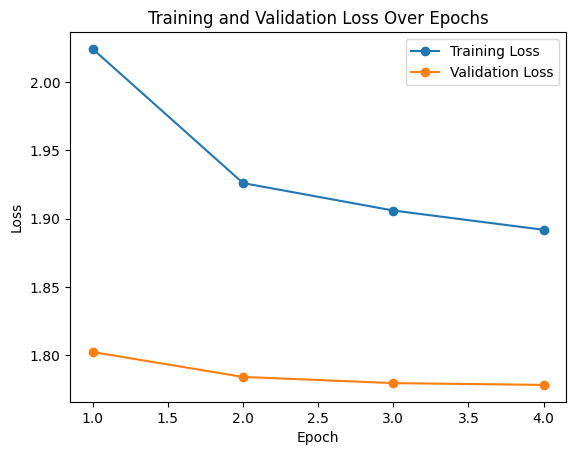

In [ ]:
import matplotlib.pyplot as plt

# Sample data
epochs = [1, 2, 3,4]
training_loss = [2.024300, 1.926100, 1.906000,1.891900]
validation_loss = [1.802418, 1.784185, 1.779669,1.778342]

# Plot training and validation loss
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Display the plot
plt.show()

# Observations :

1. Both training and validation losses consistently decrease as the number of epochs increases
2. The training and validation losses seem to converge, especially towards the later epochs
3.The gap between training and validation losses is relatively small, indicating that the model is not overfitting the training data
4. The final training loss after epoch 4 is 1.891900, and the final validation loss is 1.778342.
These values provide an indication of the model's overall performance on the training and validation sets.


In [ ]:
# Save model
import joblib
joblib.dump(model,"model.pkl")

['model.pkl']

# Prediction on Test Data

In [ ]:
# Preparing dataset of a sample of 50 records from test set

raw_test = create_dataset(df_test,50,'test')
raw_test

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights'],
        num_rows: 50
    })
})

In [ ]:
# Preprocess
# Apply tokenizing function

tokenized_test = raw_test.map(preprocess_function,batched=True)
tokenized_test

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 50
    })
})

In [ ]:
# Create pipeline object

savedmodel = pipeline('summarization',
                      model='cnn_summarization/checkpoint-1000',
                                            device=0)

In [ ]:
# Predictions

outputs = savedmodel(tokenized_test['train']['article'],max_length=100)

Token indices sequence length is longer than the specified maximum sequence length for this model (1514 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print(raw_test['train']['article'][1])
outputs[1]

A woman of Arab and Jewish descent who was strip-searched at a Detroit-area airport has reached a settlement in a lawsuit filed on her behalf, the American Civil Liberties Union said Tuesday. The federal government will give Shoshana Hebshi $40,000 as compensation for being humiliated on the 10th anniversary of the 9/11 terrorist attacks after armed agents forced her from a plane at Detroit Metropolitan Airport, made her undress during a search and held her for hours. Frontier Airlines, the Transportation Security Administration and Wayne County Airport Authority were named in the federal lawsuit. Won her case: Shoshana Hebshi, of Sylvania, Ohio, who was strip-searched at a Detroit-area airport, will gain $40,000 as compensation for being humiliated . Yoga instructor: Hebshi works as a freelance writer, yoga instructor, and is a mother to two twins . Hebshi, who has a Jewish mother and Saudi Arabian father, has said she was ethnically profiled based on her dark complexion. 'I filed thi

{'summary_text': 'Shoshana Hebshi, of Sylvania, Ohio, was strip-searched at Detroit Metropolitan Airport on the 10th anniversary of 9/11 . The federal government will give her $40,000 as compensation for being humiliated after armed agents forced her from a plane, made her undress during a search and held her for hours . Frontier Airlines, the Transportation Security Administration and Wayne County Airport Authority were named in the federal lawsuit .'}

# Transformers - Pretrained on  CNN dataset

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

In [ ]:
model_name = "facebook/bart-large-cnn"

# Load the BART tokenizer and model
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
# Function to generate summaries
def generate_summary(article_text):
    inputs = tokenizer.encode("summarize: " + article_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=100, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [ ]:
predictions_llm = []
for i in range(10):
  Predicted_summary = generate_summary(df_test['article'][i])
  predictions_llm.append(Predicted_summary)

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(predictions, df_test["highlights"].tolist(), avg=True)

# Print the ROUGE scores
print(f"ROUGE-1: {scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {scores['rouge-l']['f']:.4f}")

ROUGE-1: 0.1840
ROUGE-2: 0.0436
ROUGE-L: 0.1732


In [ ]:
!pip install prettytable

from prettytable import PrettyTable
# Create a PrettyTable object
table = PrettyTable()

# Define the table headers
table.field_names = ["Models", "ROUGE-1", "ROUGE-2", "ROUGE-L"]

table.add_row(["TF-IDF", 0.1840,0.0436,0.1732])
table.add_row(["TextRank", 0.3313,0.1270,0.3084])
table.add_row(["Seq2Seq ", 0.240800,0.116600,0.199300])
table.add_row(["BART", 0.1840, 0.0436,0.1732])

# Print the table
print(table)

+----------+---------+---------+---------+
|  Models  | ROUGE-1 | ROUGE-2 | ROUGE-L |
+----------+---------+---------+---------+
|  TF-IDF  |  0.184  |  0.0436 |  0.1732 |
| TextRank |  0.3313 |  0.127  |  0.3084 |
| Seq2Seq  |  0.2408 |  0.1166 |  0.1993 |
|   BART   |  0.184  |  0.0436 |  0.1732 |
+----------+---------+---------+---------+
